In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

from collections import defaultdict

In [2]:
downsample_factor = 16

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

NameError: name 'xy_pixel_distance_lossless' is not defined

In [4]:
def compute_score(T):
        
    score = 0
    for name in available_labels_unsided:
        
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)
    
        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)
        
        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
        voxel_probs_valid = volume2_allLabels[name][ys_prime[valid], xs_prime[valid], zs_prime[valid]] / 1e4

        score += label_weights[name] * voxel_probs_valid.sum()
                
        del voxel_probs_valid, valid, xs_prime, ys_prime, zs_prime, pts_prime
                
    return score

In [5]:
parameters_allStacks = {}
atlas_centroid_allStacks = {}
test_centroid_allStacks = {}
test_dims_allStacks = {}

for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):

    with open(atlasAlignParams_rootdir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
        lines = f.readlines()
        
    parameters_allStacks[stack] = np.array(map(float, lines[0].strip().split()))
    atlas_centroid_allStacks[stack] = np.array(map(float, lines[2].strip().split()))
    test_dims_allStacks[stack] = np.array(map(int, lines[3].strip().split()))
    test_centroid_allStacks[stack] = np.array(map(float, lines[4].strip().split()))

In [6]:
hessian_allStacks = {}
std_allStacks = {}

In [7]:
import numdifftools as nd
# https://media.readthedocs.org/pdf/numdifftools/latest/numdifftools.pdf

In [8]:
# atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, 'MD589/volume_MD589_annotation_withOuterContour.bp'))
atlas_volume = bp.unpack_ndarray_file(volume_dir + '/atlasVolume_icp.bp')

atlas_ydim, atlas_xdim, atlas_zdim = atlas_volume.shape
atlas_centroid = atlas_centroid_allStacks[stack]
print atlas_centroid

[ 303.   200.5  265.5]


In [9]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(atlas_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [10]:
def parallel_where(name, num_samples=None):
    
    w = np.where(atlas_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlas_nzs = Parallel(n_jobs=8)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
atlas_nzs = dict(zip(available_labels_sided, atlas_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 3.388373 seconds


In [11]:
pts_centered = {name: (np.concatenate([atlas_nzs[n] for n in labelMap_unsidedToSided[name]]) - atlas_centroid).astype(np.int16) 
                         for name in available_labels_unsided}

In [12]:
label_weights = {name: .1 if name == 'outerContour' else 1. for name in available_labels_unsided}

In [13]:
scores_allStack = {}

In [14]:
def compute_scores_neighborhood_grid(params, dxs, dys, dzs):
    
    from itertools import product

    scores = np.reshape(Parallel(n_jobs=12)(delayed(compute_score)(params + (0.,0.,0., dx, 0.,0.,0., dy, 0.,0.,0., dz)) 
                                            for dx, dy, dz in product(dxs, dys, dzs)), 
                        (dxs.size, dys.size, dzs.size))
    
    return scores

def compute_scores_neighborhood_random(params, n, stds):
    
    dparams = np.random.uniform(-1., 1., (n, stds.size)) * stds
        
    scores = Parallel(n_jobs=12)(delayed(compute_score)(params + dp) for dp in dparams)
    
    return scores

In [15]:
hessian_allStacks = pickle.load(open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/hessian_globalAlign_allStacks.pkl', 'r'))
std_allStacks = pickle.load(open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/std_globalAlign_allStacks.pkl', 'r'))

MD589
838

load score volumes: 25.922263 seconds
Compute hessian: 78.277727 seconds


 460 454
[ 419.  230.  227.]


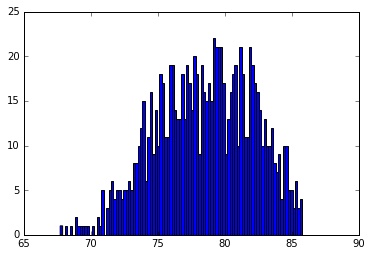

MD594
844

Compute std: 25.848567 seconds
load score volumes: 29.286838 seconds


 484 443
[ 422.   242.   221.5]


Compute hessian: 81.394113 seconds


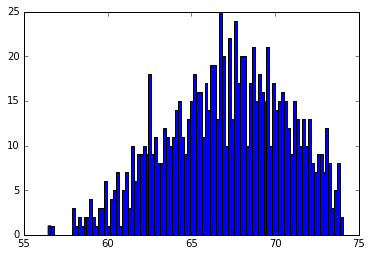

MD585
822

Compute std: 26.729176 seconds
load score volumes: 26.255502 seconds


 450 438
[ 411.  225.  219.]


Compute hessian: 77.783783 seconds


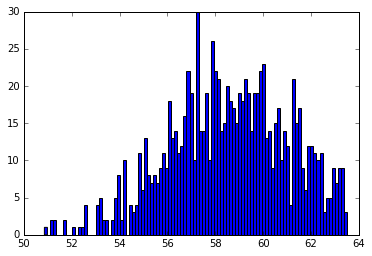

MD590
822

Compute std: 26.479664 seconds
load score volumes: 24.976174 seconds


 472 397
[ 411.   236.   198.5]


Compute hessian: 78.826561 seconds


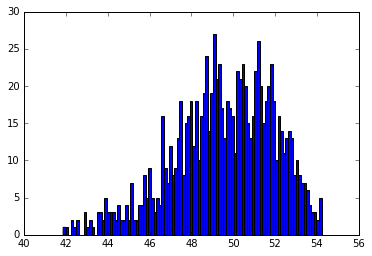

MD593
736

Compute std: 26.662098 seconds
load score volumes: 24.759193 seconds


 480 456
[ 368.  240.  228.]


Compute hessian: 78.049482 seconds


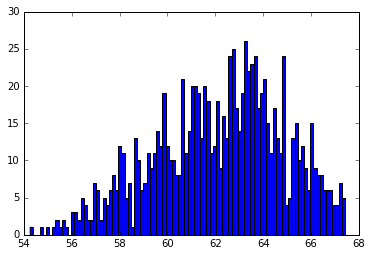

MD592
838

Compute std: 27.855437 seconds
load score volumes: 30.787323 seconds


 482 470
[ 419.  241.  235.]


Compute hessian: 80.425659 seconds


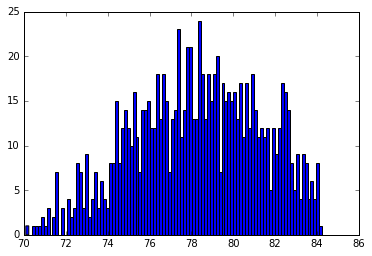

MD591
820

Compute std: 26.954307 seconds
load score volumes: 34.450073 seconds


 544 451
[ 410.   272.   225.5]


Compute hessian: 79.010904 seconds


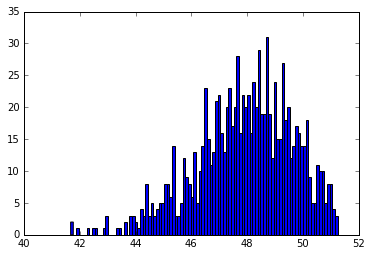

MD595
874

Compute std: 26.773796 seconds
load score volumes: 30.393927 seconds


 472 448
[ 437.  236.  224.]


Compute hessian: 79.436999 seconds


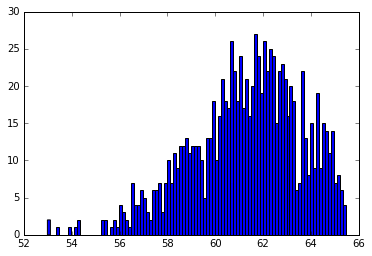

MD598
900

Compute std: 27.871988 seconds
load score volumes: 27.834038 seconds


 462 410
[ 450.  231.  205.]


Compute hessian: 78.179052 seconds


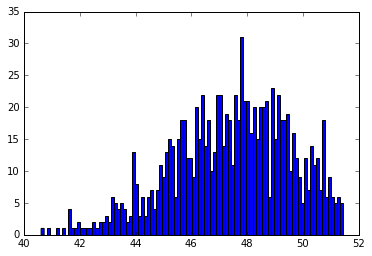

MD602
936

Compute std: 27.465414 seconds
load score volumes: 28.584635 seconds


 438 424
[ 468.  219.  212.]


Compute hessian: 80.673915 seconds


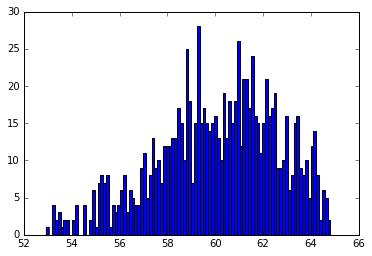

MD603
1056

Compute std: 26.756140 seconds
load score volumes: 33.546012 seconds


 472 437
[ 528.   236.   218.5]


Compute hessian: 80.081895 seconds


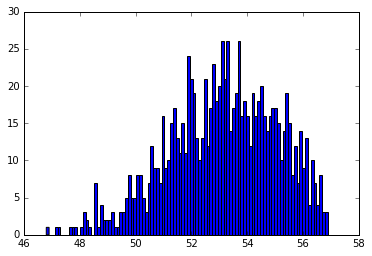

Compute std: 27.180708 seconds


In [27]:
for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):
# for i, stack in enumerate(['MD593']):
    
    print stack
    
    ################################
       
    t = time.time()

    volume2_allLabels = {}

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                          {'stack': stack, 'label': name})).astype(np.float16)
        volume2_allLabels[name] = volume2_roi
        del volume2_roi

    test_xdim, test_ydim, test_zdim = test_dims_allStacks[stack]
    test_centroid = test_centroid_allStacks[stack]

    print test_xdim, test_ydim, test_zdim
    print test_centroid

    sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))
    
    t = time.time()

    h = nd.Hessian(lambda t: compute_score(t), step=np.r_[1e-1, 1e-1, 1e-1, 10,
                                          1e-1, 1e-1, 1e-1, 10,
                                          1e-1, 1e-1, 1e-1, 10])

    H = h(parameters_allStacks[stack])
    hessian_allStacks[stack] = H
    
    sys.stderr.write('Compute hessian: %f seconds\n' % (time.time() - t))

    
    t = time.time()
    
#     dt = np.arange(-10, 11, 1.)
#     scores = compute_scores_neighborhood_grid(parameters_allStacks[stack], dt, dt, dt)
    
    
    # note: size of neighborhood affects std, because the farther away from optimum the lower the scores are
    n = 1000
    scores = np.asarray(compute_scores_neighborhood_random(parameters_allStacks[stack], n, 
                                                np.r_[0, 0, 0, 10., 0, 0, 0, 10., 0, 0, 0, 10.]))
    
    std = np.std(scores.flat)
    std_allStacks[stack] = std
    
    plt.hist(scores.flatten(), bins=100);
    plt.show();
    
    sys.stderr.write('Compute std: %f seconds\n' % (time.time() - t))

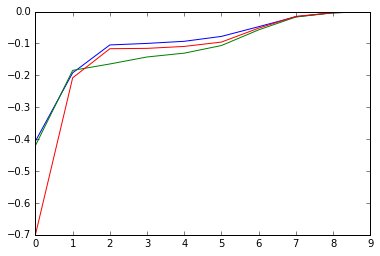

In [189]:
# Test hessian sensitivity to step size; seems translation step size = 10 is a stable zone

# hs = []
# for dt in np.logspace(0, 3, 10) / 5:

#     h = nd.Hessian(lambda t: compute_score(t), step=np.r_[1e-1, 1e-1, 1e-1, dt, 1e-1, 1e-1, 1e-1, dt, 1e-1, 1e-1, 1e-1, dt])
#     H = h(parameters_allStacks[stack])
#     hs.append(np.diag(H)[[3,7,11]])
    
# plt.plot(hs);

In [21]:
print 'step size =', xy_pixel_distance_downsampled * 10, 'um'

step size = 73.6 um


In [27]:
z1 = {}
z2 = {}
z3 = {}
z4 = {}

for i, stack in enumerate(['MD589', 'MD594', 'MD585', 'MD590', 'MD593', 'MD592', 'MD591', 'MD595', 'MD598', 'MD602', 'MD603']):

    H = hessian_allStacks[stack]
    std = std_allStacks[stack]

    U, S, VT = np.linalg.svd(H[np.r_[3,7,11], np.r_[3,7,11][:,None]])
    z1[stack] = 1./2. * 10**2 * -S[2] / std
    z2[stack] = 1./6. * (5**2+5*20+20**2) * -S[2] / std
    
    z3[stack] = 1./2. * 10**2 * -S[0] / std
    z4[stack] = 1./6. * (5**2+5*20+20**2) * -S[0] / std

In [17]:
print np.mean(z0.values())
print np.mean(z1.values())
print np.mean(z2.values())

-0.0119844476839
-1.19844476839
-2.09727834469


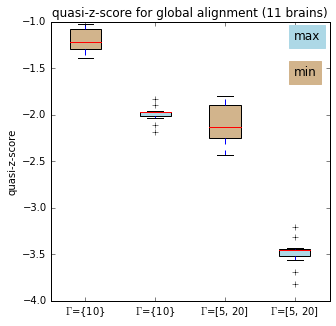

In [49]:
plt.figure(figsize=(5,5));

box = plt.boxplot(np.c_[z1.values(), z3.values(), z2.values(), z4.values()],
                 notch=False, sym='+', patch_artist=True);

colors = ['tan', 'lightblue'] * 2
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('k')

plt.xticks(range(1,1+4), ['$\Gamma$={10}', '$\Gamma$={10}', '$\Gamma$=[5, 20]', '$\Gamma$=[5, 20]']);
plt.ylabel('quasi-z-score');
plt.title('quasi-z-score for global alignment (11 brains)');

plt.figtext(0.80, 0.75, 'min', backgroundcolor='tan', weight='roman', size='large');
plt.figtext(0.80, 0.85, 'max', backgroundcolor='lightblue', weight='roman', size='large');

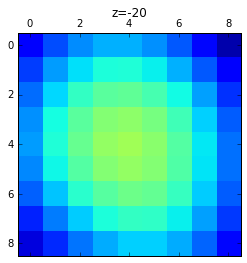

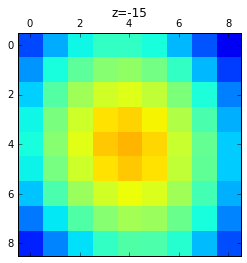

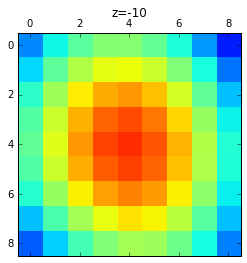

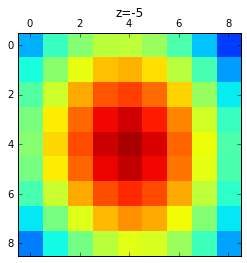

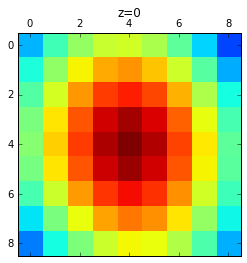

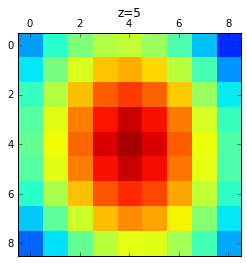

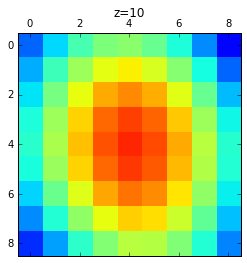

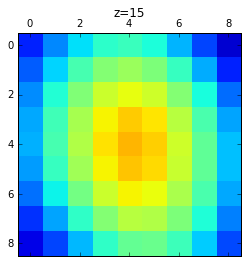

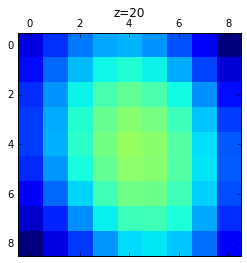

In [160]:
for zi, z in enumerate(dt):
    plt.matshow(scores[:,:,zi], vmin=scores.min(), vmax=scores.max());
    plt.title('z=%d' % z);
    plt.show();

In [28]:
pickle.dump(hessian_allStacks, open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/hessian_globalAlign_allStacks.pkl', 'w'))
pickle.dump(std_allStacks, open('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas/std_globalAlign_allStacks.pkl', 'w'))